In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
THETA = 3 # in degrees
MASS = 6e3 # in kg
DT = 0.001 # in seconds

def thrust(alpha,theta=np.deg2rad(THETA),T=(1e6 + MASS*1*9.8)/np.cos(np.deg2rad(THETA))):
    """ 
    calculates thrust in inertial (parent) direction
    inputs:
    - alpha in rad
    - theta in rad
    - T in N (absolute value of net thrust)

    output:
    - 2D vector

    Notes: value of T*cos(theta) = Drag + ma
    """
    return np.array([T*np.cos(-alpha+theta),-T*np.sin(-alpha+theta)-9.8*6e3])

def drag(alpha,beta,D = 1e6):
    """
    calculates drag in inertial (parent) direction
    inputs:
    - alpha in rad
    - beta in rad
    - D in N (absolute value of net thrust)

    output: 
    - 2D vector
    """
    return np.array([-D*np.cos(beta-alpha),D*np.sin(beta-alpha)])

def R_i2b(alpha,vec):
    """ 
    returns rotated vector in the body frame (x,y) from the interial {parent (X,Y)}
    alpha in rad
    """
    rotMat = np.array( [ [ np.cos(alpha), np.sin(alpha) ], [ -np.sin(alpha), np.cos(alpha)] ] )   
    return np.matmul(rotMat,vec)

def moment(alpha, drag, l = 0.1):
    """ 
    calculates positive value standard right hand rule i.e. outside plane moment is positive
    l is distance between cg and cp
    distance between cg and ct is assumed 0 {ct is the point at which thrust acts}
    """
    dragRot = -R_i2b(alpha,drag)
    return dragRot[1]*l

def moi(m=6000,r=2.5,l=5):
    """
    moment of intertia, will be used in future for variable mass and exact CG location
    """
    return m*(0.25*r**2 + (1/12)*l**2)


def betaFromV(alpha, v):
    """
    input:
    - alpha in radians
    - velocity vector in inertial frame
    output:
    - in radians
    """
    vRot = R_i2b(alpha,v) # transform velcity vector from parent to pod frame
    return np.arctan(-vRot[1]/vRot[0])

def updateV(vo, T, D, dt = DT, m = MASS):
    """
    newton's law
    """
    # return vo + ((T+D)/m+np.array([0,-9.8]))*dt # for absolute displacement in Y (but first have to rotate everything in real inertial frame)
    return vo + ((T+D)/m)*dt

def updateAlphadot(alphaDot, moment, moi, dt = DT):
    """
    we know that doube derivative of alpha wrt time is net_Torque/Moment of inertia
    input:
    - rad/sec
    - N-m
    - kg-m^2
    """
    return alphaDot + (moment/moi)*dt

def updateAlpha(alphao, alphaDot, dt = DT):
    """ 
    took modulus for plots
    """
    # return (alphao + alphaDot*dt)%(2*np.pi)
    return (alphao + alphaDot*dt)

def getAngle(vec):
    return np.arctan(vec[1]/vec[0])


In [2]:
def loopAll(cg_cp = 0.1, theta = 0,loopTime = 5):
    MASS = 6e3
    #declaring empty arrays
    t = np.arange(0,loopTime+DT,DT) 
    alph = np.zeros(len(t))
    bet = np.zeros(len(t))
    T = np.zeros((len(t),2))
    D = np.zeros((len(t),2))
    V = np.zeros((len(t),2))
    alphDot = np.zeros(len(t))
    tau = np.zeros(len(t)) 

    # initializing t = 0 values
    T[0] = thrust(alph[0],np.deg2rad(theta),0)
    D[0] = drag(alph[0],bet[0],0)
    V[0] = np.array([10,0])
    I = moi()
    for i in range(1,len(t)):
        V[i] = updateV(V[i-1],T[i-1],D[i-1])
        bet[i] = betaFromV(alph[i-1],V[i])
        tau[i] = moment(alph[i-1],D[i-1],cg_cp)
        alphDot[i] = updateAlphadot(alphDot[i-1],tau[i],I)
        alph[i] = updateAlpha(alph[i-1],alphDot[i-1])
        T[i] = thrust(alph[i],np.deg2rad(theta),0)
        D[i] = drag(alph[i],bet[i],0)
    return alph,bet,V

In [3]:
alph,bet,v=loopAll()

In [4]:
def s(V):
    s_x = V[:,0]*DT
    s_y = V[:,1]*DT
    s_x = s_x.cumsum()
    s_y = s_y.cumsum()
    return s_x,s_y

In [5]:
disp = s(v)

In [6]:
t = np.arange(0,5+DT,DT)
sx = 10*t
sy = -0.5*9.8*t**2

Text(0, 0.5, 'y displacement in meters')

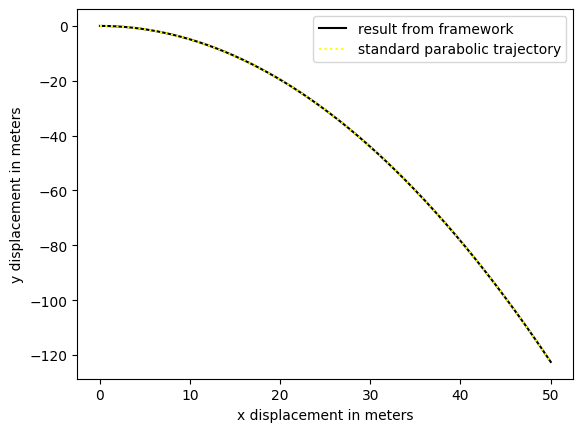

In [7]:
plt.plot(disp[0],disp[1],color = 'black')
plt.plot(sx,sy,linestyle = 'dotted',color = 'yellow')
plt.legend(['result from framework','standard parabolic trajectory'])
plt.xlabel('x displacement in meters')
plt.ylabel('y displacement in meters')